### Importing libraries and variable definitions

In [99]:
### Import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import joblib

In [154]:
# Display all columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None
# Disable scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [155]:
# Load the data
data = pd.read_pickle("../data/BRFSS2022_modeling_data.pkl")
# data.head()

### Prepping up data: Train-Test split and Oversampling / Undersampling

In [158]:
# Train-test split
X = data.drop(columns=["CVDINFR4"])
y = data["CVDINFR4"]

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [159]:
# Balance the training data using SMOTEENN, SMOTE and Under-sampling
sme = SMOTEENN(random_state=42, enn=EditedNearestNeighbours(sampling_strategy="all")) 
sm = SMOTE(random_state=42)
rus = RandomUnderSampler(random_state=42)
X_train_smoteenn, y_train_smoteenn = sme.fit_resample(X_train_raw, y_train_raw)
X_train_smote, y_train_smote = sm.fit_resample(X_train_raw, y_train_raw)
X_train_undersample, y_train_undersample = rus.fit_resample(X_train_raw, y_train_raw)

#### Tried all sampling techniques and found that they gives similar results

In [160]:
# Keep only 10% of the training data for to check the model execution and performance
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_undersample, y_train_undersample, test_size=0.5, random_state=42
)

In [161]:
# Define scaler to scale the data
scaler = StandardScaler()

In [162]:
# Scale Training and Testing Data. Fit transform separately to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train_sample)
X_test_scaled = scaler.fit_transform(X_test_raw)

In [163]:
# Assigning Train and Test data
X_train = X_train_scaled
y_train = y_train_sample
X_test = X_test_scaled
y_test = y_test_raw

In [164]:
# Checking the shape of the data
print(f"Train Shape={X_train.shape} \tTest shape={X_test.shape} \
      \n1s in train={y_train.sum():,}, \t%1s in train={y_train.sum() / len(y_train):0.1%} \
       \n1s in test={y_test.sum():,}, \t%1s in test={y_test.sum() / len(y_test):0.1%}")

Train Shape=(8182, 68) 	Test shape=(37781, 68)       
1s in train=4,076.0, 	%1s in train=49.8%        
1s in test=1,944.0, 	%1s in test=5.1%


## Modeling

### Logistic Regression

#### Grid Search

Fitting 2 folds for each of 19 candidates, totalling 38 fits
Best parameters found:  {'C': 0.1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.58      0.73     35837
         1.0       0.11      0.94      0.19      1944

    accuracy                           0.60     37781
   macro avg       0.55      0.76      0.46     37781
weighted avg       0.95      0.60      0.70     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,20737,15100
Actual 1,124,1820


Accuracy: 0.5970461343003097
Precision: 0.10756501182033097
Recall: 0.9362139917695473


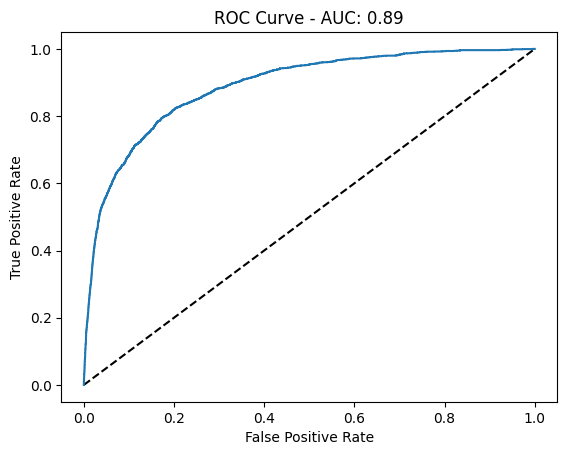

In [165]:
# Create the parameter grid based on the results of random search
param_grid = [
    {"solver": ["liblinear"], "penalty": ["l1"], "C": [1e-6], "max_iter": [int(1e6)]},
    {
        "solver": ["newton-cg", "lbfgs", "liblinear"],
        "penalty": ["l2"],
        "max_iter": [50, 100],
        "C": [0.01, 0.1, 1],
    },
]

# Create a base model
clf_logistic = LogisticRegression()

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the grid search model with precision as the scoring function
grid_search = GridSearchCV(
    estimator=clf_logistic,
    param_grid=param_grid,
    scoring=precision_scorer,
    cv=2,
    n_jobs=-1,
    verbose=5,
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

# Predict the test set using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
print ("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC: {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

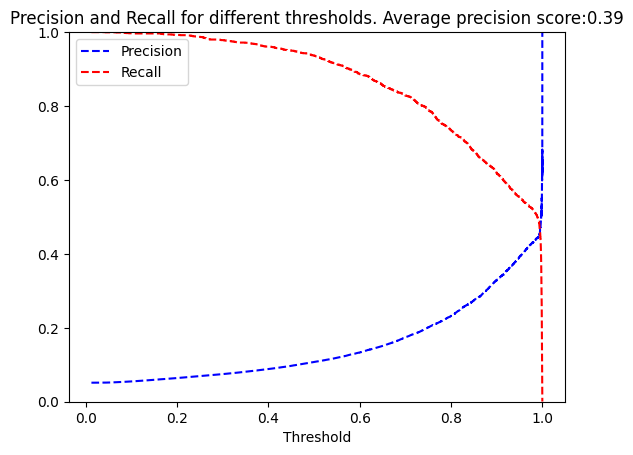

In [166]:
# Printing precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "r--", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.title(f"Precision and Recall for different thresholds. Average precision score:{average_precision_score(y_test, y_pred_prob):0.2f}")
plt.ylim([0, 1])
plt.show()



Best estimator:LogisticRegression(C=0.1, max_iter=50, solver='newton-cg')


Best parameters:{'C': 0.1, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}


Best score:0.8285198252688173


Best index:7


Best average score:[0.         0.82723975 0.8276368  0.82748812 0.82723975 0.8276368
 0.82748812 0.82851983 0.82821241 0.82843211 0.82851983 0.82821241
 0.82843211 0.82776773 0.82745381 0.82802897 0.82776773 0.82745381
 0.82802897]


Best results:{'mean_fit_time': array([0.02509391, 0.06027257, 0.03012049, 0.17112195, 0.05244613,
       0.02835619, 0.12149739, 0.06601322, 0.0399344 , 0.23586118,
       0.07276332, 0.04023373, 0.31701005, 0.11711586, 0.05516064,
       0.30140877, 0.11710167, 0.03383183, 0.24761772]), 'std_fit_time': array([0.00250232, 0.00944293, 0.00353205, 0.01056612, 0.00123549,
       0.00025094, 0.00399041, 0.00577986, 0.00428057, 0.00499642,
       0.0040251 , 0.00195301, 0.04890072, 0.00953233, 0.0105027 ,
       0.00906873, 0.00636458, 0.00654006, 0.01668

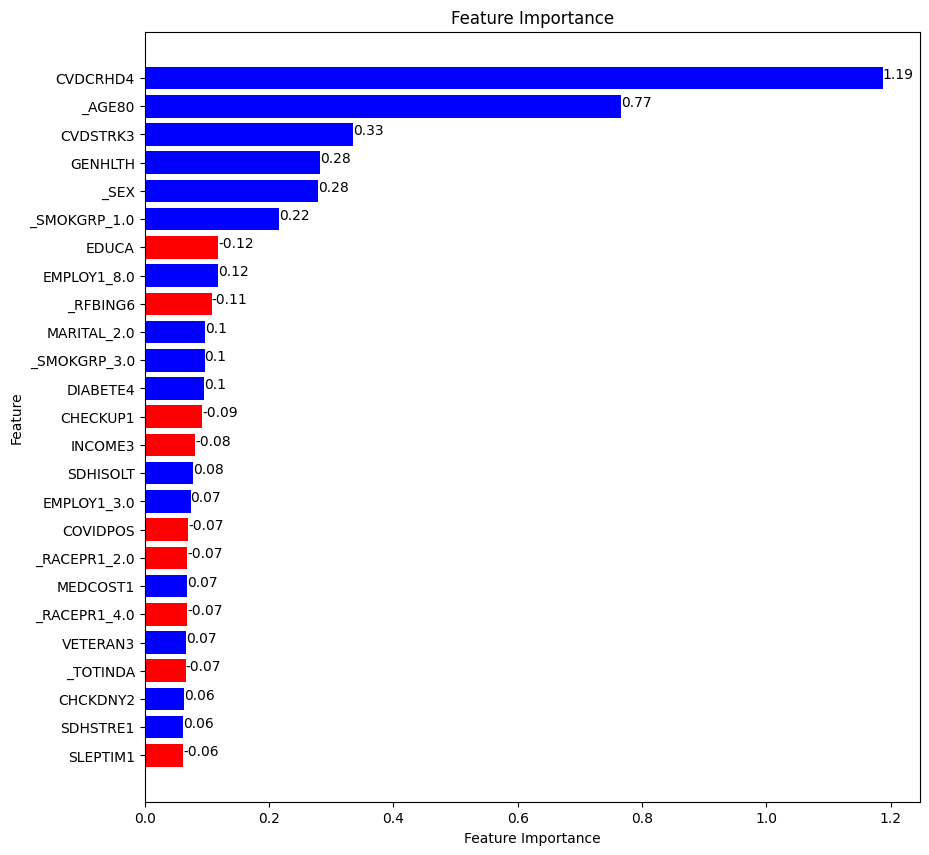

In [167]:
# Print the best model
print(f"\n\nBest estimator:{grid_search.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{grid_search.best_params_}")

# Print the best score
print(f"\n\nBest score:{grid_search.best_score_}")

# Print the best index
print(f"\n\nBest index:{grid_search.best_index_}")

# Print average score
print(f"\n\nBest average score:{grid_search.cv_results_['mean_test_score']}")

# Print the results
print(f"\n\nBest results:{grid_search.cv_results_}")

# Count the number of features with negative coefficients
negative_coefficients = sum(grid_search.best_estimator_.coef_[0] < 0)
print(f"\n\nNumber of features with negative coefficients: {negative_coefficients}")

# Plot feature importance
feature_importance = dict(zip(X.columns, zip(np.abs(grid_search.best_estimator_.coef_[0]), np.where(grid_search.best_estimator_.coef_[0]>=0, 1, -1))))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1][0], reverse=False)
print ("\n\nFeature importance:")
for feature in sorted_features:
    print(feature)

# Plot feature importance with feature importance values as data labels
plt.figure(figsize=(10, 10))
top_n = 25
colors = ["blue" if x[1][1]==1 else "red" for x in sorted_features[-top_n:]]
plt.barh(
    [x[0] for x in sorted_features[-top_n:]],
    [x[1][0] for x in sorted_features[-top_n:]],
    color=colors,
)
for index, value in enumerate([x[1] for x in sorted_features[-top_n:]]):
    plt.text(value[0], index, str(value[1]*round(value[0], 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


In [168]:
X.CVDCRHD4.value_counts()

CVDCRHD4
0.0    177306
1.0     11599
Name: count, dtype: int64

In [169]:
# Save the model
joblib.dump(grid_search.best_estimator_, '../models/lr_model.pkl')

# Save the test set
# X_test.to_pickle('../data/logistic_regression_test_set.pkl')
# y_test.to_pickle('../data/logistic_regression_test_labels.pkl')

# Save the ROC curve
# roc_curve_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
# roc_curve_data.to_pickle('../data/logistic_regression_roc_curve.pkl')

# Save the classification report
# classification_report_data = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
# classification_report_data.to_pickle('../data/logistic_regression_classification_report.pkl')

# Save the confusion matrix
# confusion_matrix_data = pd.DataFrame(confusion_matrix(y_test, y_pred))

# confusion_matrix_data.to_pickle('../data/logistic_regression_confusion_matrix.pkl')

# Save the AUC
# auc_data = pd.DataFrame({'AUC': [roc_auc_score(y_test, y_pred_prob)]})
# auc_data.to_pickle('../data/logistic_regression_auc.pkl')

# Save the hyperparameters
# hyperparameters = pd.DataFrame({'C': [grid_search.best_params_['C']], 'penalty': [grid_search.best_params_['penalty']]})
# hyperparameters.to_pickle('../data/logistic_regression_hyperparameters.pkl')

# Save the feature importance coefficients and intercept
# Get feature names from grid_search.best_estimator_
model_coefficients=pd.DataFrame({'feature':X.columns, 'coefficient':grid_search.best_estimator_.coef_[0]})
model_intercept=pd.DataFrame({'feature':['intercept'], 'coefficient':grid_search.best_estimator_.intercept_})

# Join intercept to the model coefficients
model_coefficients=pd.concat([model_coefficients, model_intercept], ignore_index=True)

model_coefficients.to_pickle('../data/lr_model_coefficients_intercept.pkl')

In [170]:
X.CVDCRHD4.value_counts()

CVDCRHD4
0.0    177306
1.0     11599
Name: count, dtype: int64

In [171]:
print(model_coefficients[0:69])

         feature  coefficient
0        GENHLTH     0.282330
1       PHYSHLTH     0.015764
2       MENTHLTH     0.019263
3       PERSDOC3     0.026244
4       MEDCOST1     0.068009
5       CHECKUP1    -0.092137
6       SLEPTIM1    -0.061694
7       CVDCRHD4     1.187360
8       CVDSTRK3     0.334783
9       CHCOCNC1     0.015206
10      CHCCOPD3     0.028811
11      ADDEPEV3     0.042639
12      CHCKDNY2     0.063174
13      DIABETE4     0.095911
14         EDUCA    -0.118668
15      VETERAN3     0.065975
16      CHILDREN     0.021625
17       INCOME3    -0.081039
18        DECIDE     0.026049
19      DIFFALON     0.060840
20      COVIDPOS    -0.070004
21      PREDIAB2     0.042429
22      CNCRDIFF    -0.002118
23      LSATISFY    -0.005955
24      EMTSUPRT     0.054744
25      SDHISOLT     0.078489
26      SDHEMPLY     0.025597
27      FOODSTMP     0.026693
28      SDHFOOD1    -0.028027
29      SDHBILLS     0.060193
30      SDHUTILS    -0.008892
31      SDHTRNSP    -0.008434
32      SD

#### Specific LR Models

Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.58      0.73     35837
         1.0       0.11      0.94      0.19      1944

    accuracy                           0.60     37781
   macro avg       0.55      0.76      0.46     37781
weighted avg       0.95      0.60      0.71     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,20807,15030
Actual 1,125,1819


Accuracy: 0.5988724491146343
Precision: 0.10795892931331236
Recall: 0.9356995884773662


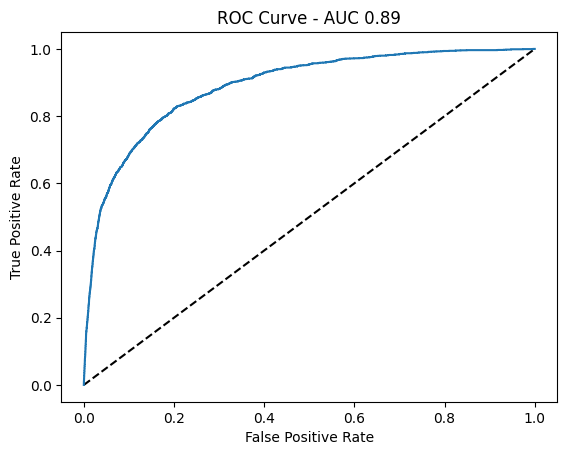

In [172]:
# Create an LR model
clf_logistic = LogisticRegression(solver= "liblinear", penalty= "l1", C= 0.1)

# Fit the grid search to the data
clf_logistic.fit(X_train, y_train)

# Predict the test set using the LR model
y_pred = clf_logistic.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = clf_logistic.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

### Random Forest

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
RandomForestClassifier(max_depth=30, min_samples_split=10, n_estimators=1000)
0.809582257508905
16
[0.80591563 0.805427   0.80567138 0.80469355 0.80554888 0.80530468
 0.80591567 0.80530459 0.80640448 0.80701556 0.8064047  0.80322701
 0.80689359 0.80579335 0.80542691 0.80493811 0.80958226 0.80310518
 0.80640461 0.80616014]
{'mean_fit_time': array([ 3.14400641,  9.69470779,  9.8551894 , 18.65887443, 15.54040154,
        6.41098062, 33.458335  ,  1.82840689, 12.01160081, 25.49409819,
        6.01803366, 16.69869065, 13.91149267, 21.28951399, 27.04540205,
       15.58211978, 12.53846264,  7.84451238, 25.12761672, 14.62478431]), 'std_fit_time': array([0.16017044, 0.30594438, 0.55248398, 0.58644976, 0.31215065,
       0.32098224, 1.13509788, 0.07233788, 1.02702904, 1.50872116,
       0.35809159, 0.2421452 , 0.20521094, 0.73121862, 0.88521215,
       1.1737107 , 1

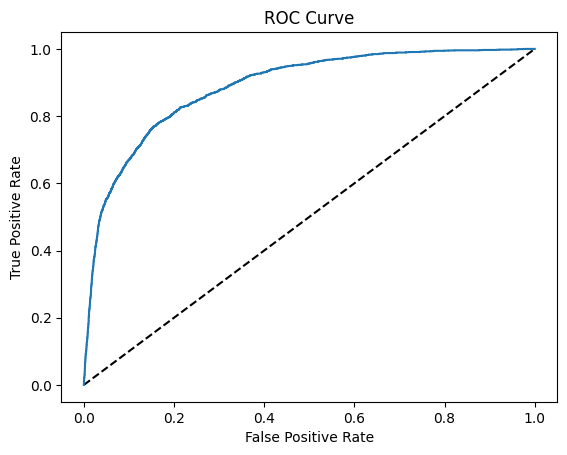

AUC: 0.8873171576701139


In [173]:
# Perform random search for hyperparameter tuning using random forest classifier
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ["log2", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf_random_forest = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
clf_random = RandomizedSearchCV(
    estimator=clf_random_forest,
    param_distributions=random_grid,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)
# Fit the random search model
clf_random.fit(X_train, y_train)

# Print the best parameters
print(clf_random.best_params_)
# Print the best model
print(clf_random.best_estimator_)
# Print the best score
print(clf_random.best_score_)
# Print the best index
print(clf_random.best_index_)
# Print average score
print(clf_random.cv_results_["mean_test_score"])
# Print the results
print(clf_random.cv_results_)
# Print feature importance
feature_importance = dict(
    zip(X.columns, clf_random.best_estimator_.feature_importances_)
)
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for feature in sorted_features:
    print(feature)

# Predict the test set using the best model
y_pred = clf_random.best_estimator_.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = clf_random.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

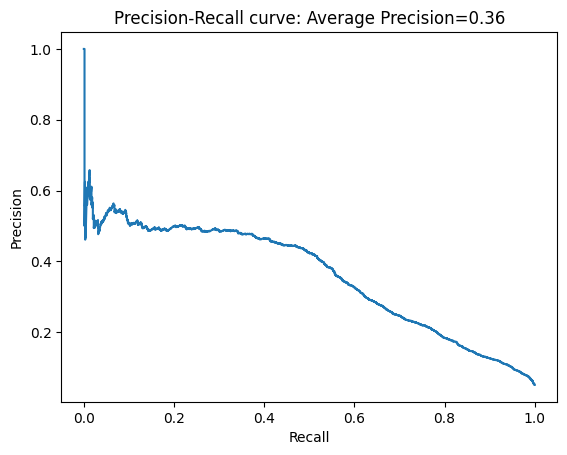

In [174]:
# Plot PR curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)
# Show the average precision in the plot

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(
    f"Precision-Recall curve: Average Precision={average_precision:0.2f}"
)
plt.show()

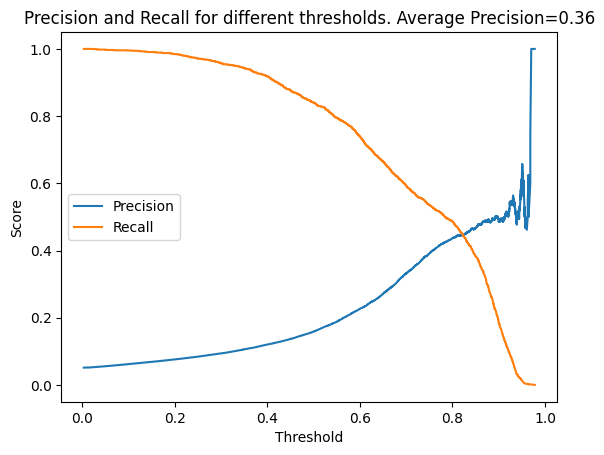

In [175]:
# Plot Precision and Recall for different thresholds
plt.plot(thresholds, precision[1:], label="Precision")
plt.plot(thresholds, recall[1:], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title(f"Precision and Recall for different thresholds. Average Precision={average_precision:0.2f}")
plt.show()

In [186]:
# Print precision and recall for different thresholds
threshold_values = np.linspace(0, 1, 11)
for threshold in threshold_values:
    if threshold > thresholds.max():
        threshold = thresholds.max()
    else:
        threshold=np.round(threshold, 2)
    precision_threshold = precision[np.where(thresholds >= threshold)[0][0]]
    recall_threshold = recall[np.where(thresholds >= threshold)[0][0]]
    print(
        f"Threshold: {threshold:0.2f}, Precision: {precision_threshold:0.2f}, Recall: {recall_threshold:0.2f}"
    )

Threshold: 0.00, Precision: 0.05, Recall: 1.00
Threshold: 0.10, Precision: 0.06, Recall: 1.00
Threshold: 0.20, Precision: 0.08, Recall: 0.98
Threshold: 0.30, Precision: 0.09, Recall: 0.96
Threshold: 0.40, Precision: 0.12, Recall: 0.92
Threshold: 0.50, Precision: 0.16, Recall: 0.84
Threshold: 0.60, Precision: 0.23, Recall: 0.74
Threshold: 0.70, Precision: 0.33, Recall: 0.59
Threshold: 0.80, Precision: 0.44, Recall: 0.49
Threshold: 0.90, Precision: 0.49, Recall: 0.19
Threshold: 0.98, Precision: 1.00, Recall: 0.00


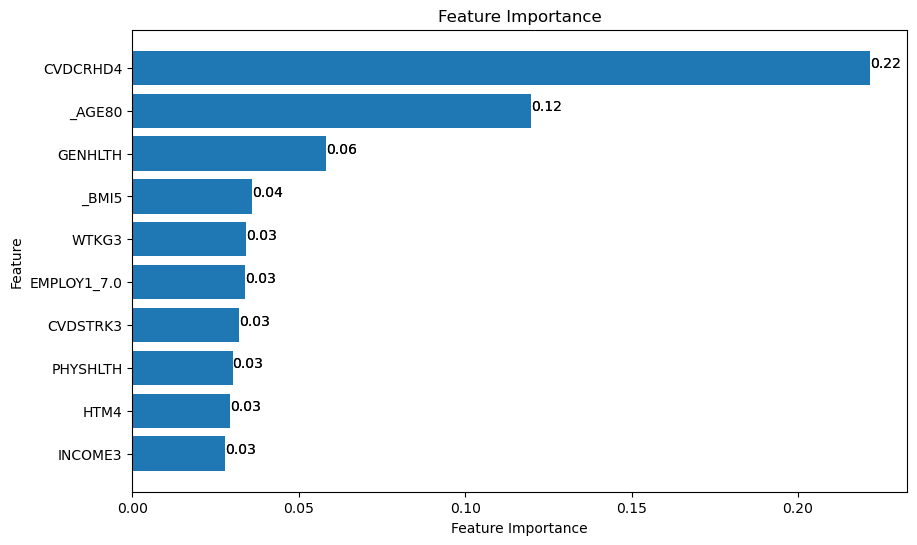

In [ ]:
# Feature importance plot with feature importance values as data labels
sorted_features_reverse = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features_reverse[-10:]],
    [x[1] for x in sorted_features_reverse[-10:]],
)

for index, value in enumerate([x[1] for x in sorted_features_reverse[-10:]]):
    plt.text(value, index, str(round(value, 2)))

# Add feature imporatance values ad data labels to the plot
for index, value in enumerate([x[1] for x in sorted_features_reverse[-10:]]):
    plt.text(value, index, str(round(value, 2)))



plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [ ]:
clf_random.cv_results_

{'mean_fit_time': array([ 1.28237597,  5.91002981,  5.49527828, 10.82817817,  8.31764619,
         4.00662271, 19.22405322,  1.36809587,  7.34209879, 13.79346983,
         3.4730715 , 10.23559769,  9.06911294, 13.12384717, 16.71516458,
         9.56932362,  8.0350457 ,  4.68196988, 15.11222156,  8.97532145]),
 'std_fit_time': array([0.06189583, 0.56153722, 0.41348649, 0.15732364, 0.29037543,
        0.17952036, 0.24704773, 0.06238224, 0.10673113, 0.49448651,
        0.14048271, 0.40344106, 0.26543435, 0.47961985, 0.24970167,
        0.40316267, 0.17526363, 0.11893334, 0.13632216, 0.07579137]),
 'mean_score_time': array([0.08730427, 0.3049825 , 0.38944642, 0.8570315 , 0.84427198,
        0.22636   , 1.33987888, 0.08425093, 0.61042595, 1.30029869,
        0.21528252, 0.62901664, 0.63917383, 0.74957403, 1.06696812,
        0.82484285, 0.52333458, 0.38416012, 0.88249795, 0.67563462]),
 'std_score_time': array([0.00370973, 0.01829661, 0.05400421, 0.07932372, 0.17535724,
        0.0392975 , 

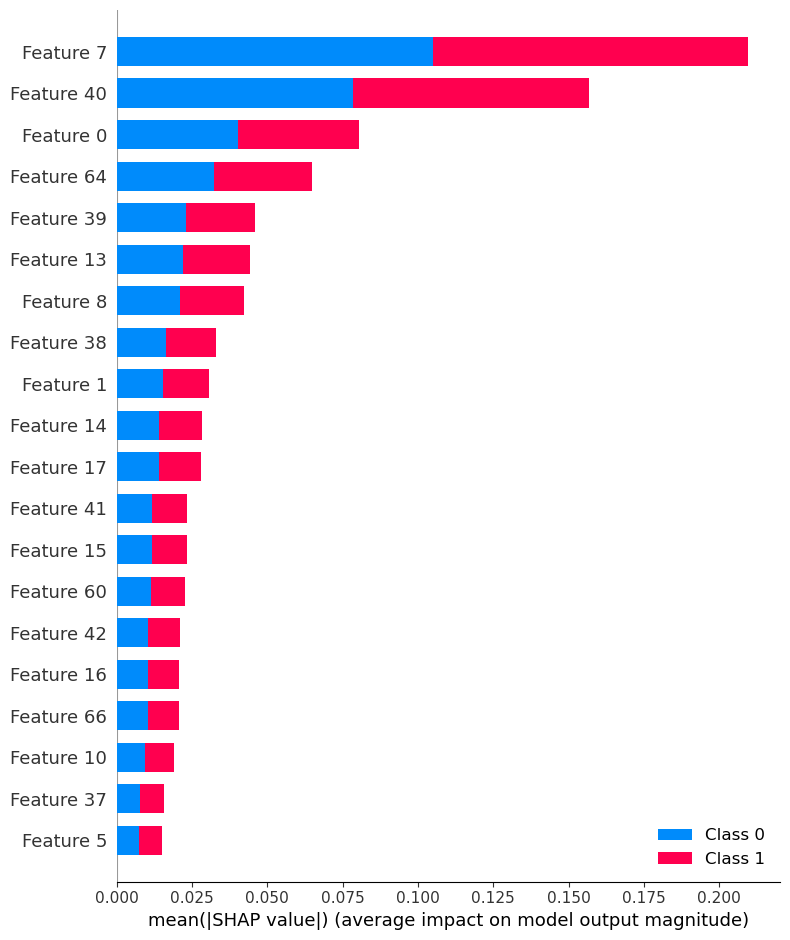

In [ ]:
# Shapley analysis with values and plot
import shap
shap.initjs()
explainer = shap.TreeExplainer(clf_random.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

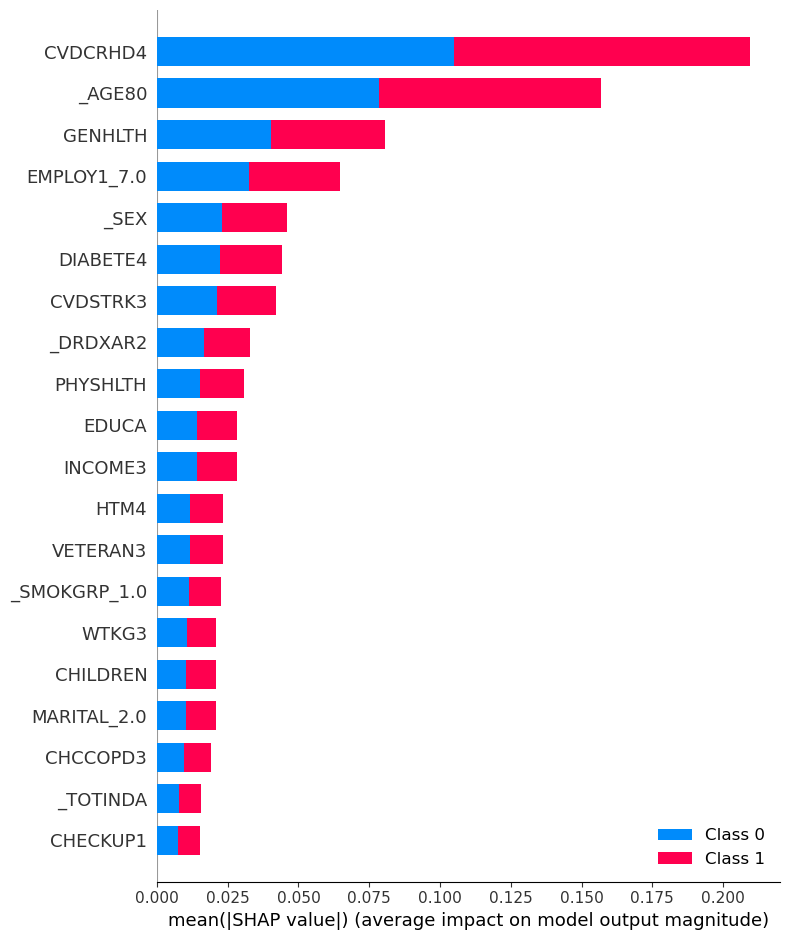

In [ ]:
# Shapley plot with feature names and values as data labels
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar")


Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead


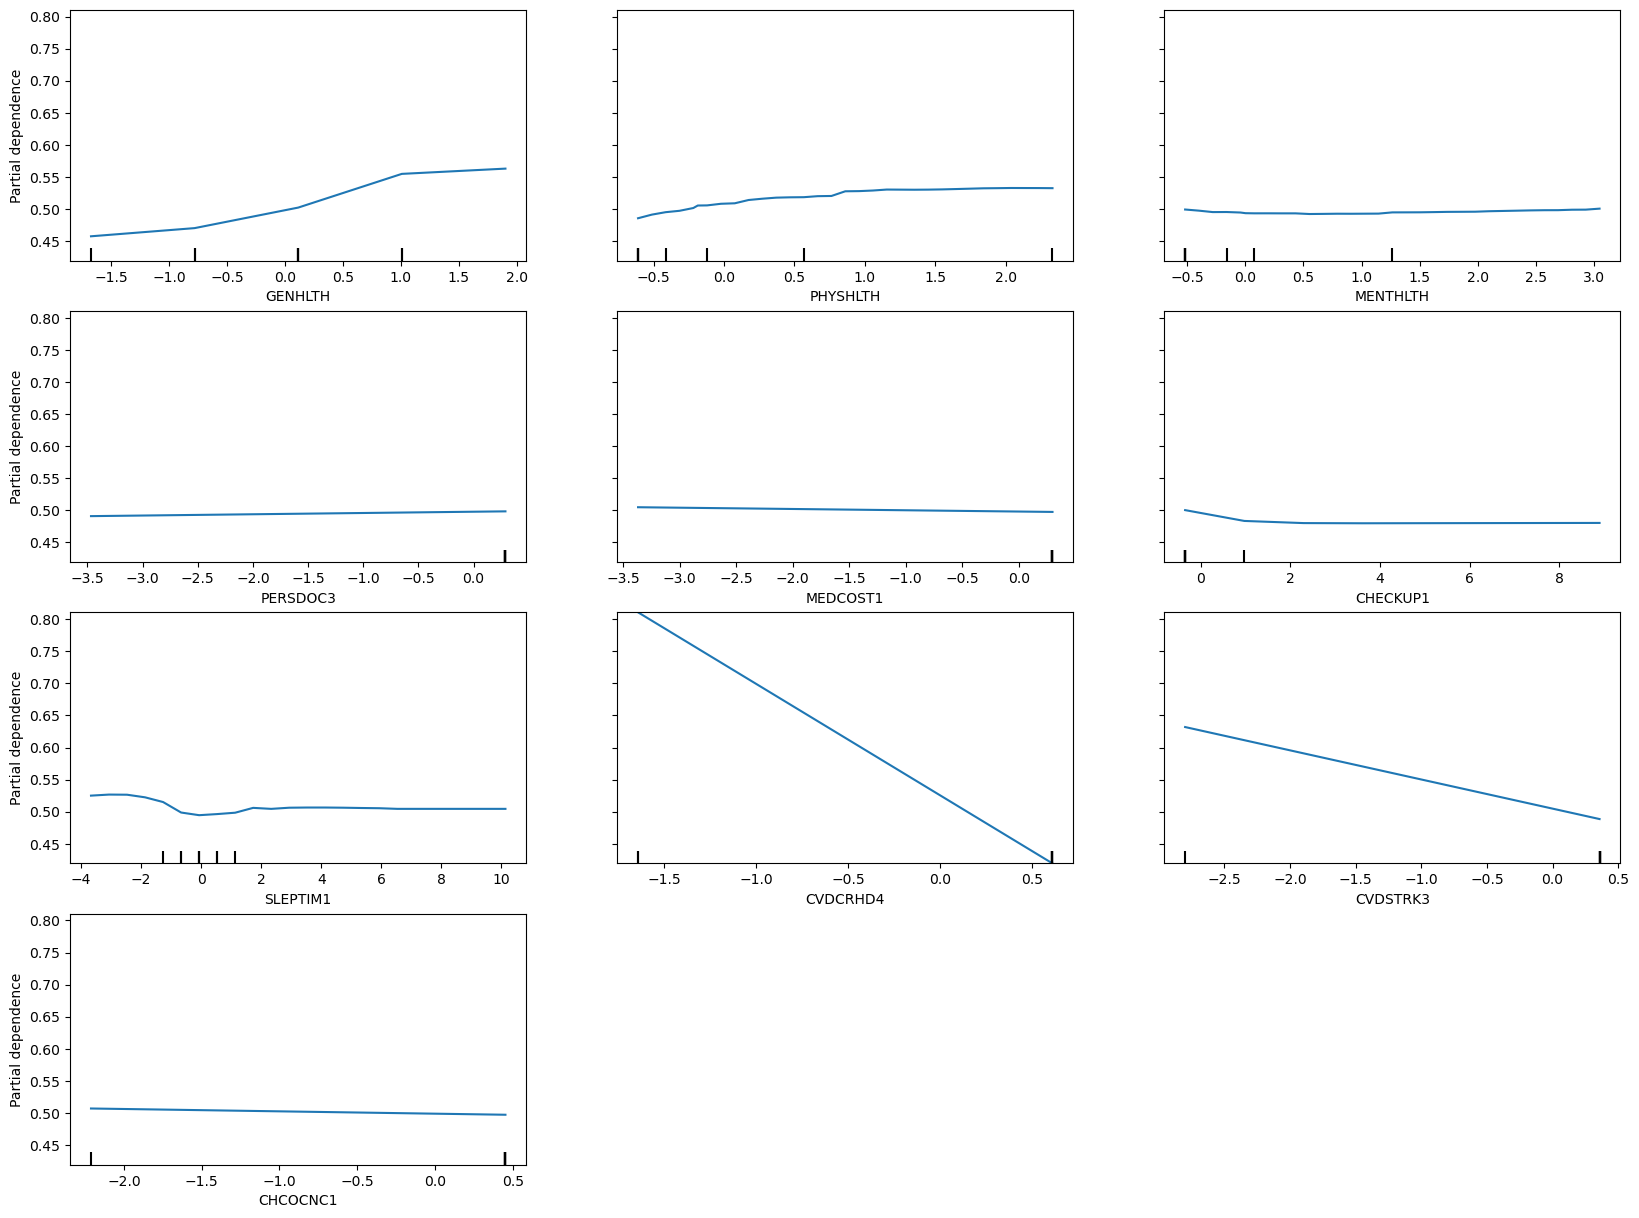

In [ ]:
# Partial dependence plot
from sklearn.inspection import plot_partial_dependence

# Set figure size
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Plot partial dependence on figure
plot_partial_dependence(clf_random.best_estimator_, X_train, features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], feature_names=X.columns, grid_resolution=50, ax=ax)
plt.show()

### XGBoost

#### Using Random Search

In [ ]:
# Create an XGBClassifier using the best parameters from the random search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=2000, num=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_child_weight = [1, 2, 4]
# Minimum number of samples required at each leaf node
gamma = [0.1, 0.2, 0.3]
# Learning rate
learning_rate = [0.01, 0.1, 0.2]
# Create the parameter grid
param_grid_xgb = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_child_weight": min_child_weight,
    "gamma": gamma,
    "learning_rate": learning_rate,
}

# Create a base model
clf_xgb = XGBClassifier(reg_alpha=0.002)

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the random search model with precision as the scoring function
grid_search_xgb = RandomizedSearchCV(
    estimator=clf_xgb,
    param_distributions=param_grid_xgb,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring=precision_scorer,
)

# Fit the grid search to the data
grid_search_xgb.fit(X_train, y_train)
print("Best parameters found: ", grid_search_xgb.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:  {'n_estimators': 480, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.2}


Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     35837
           1       0.05      1.00      0.10      1944

    accuracy                           0.05     37781
   macro avg       0.03      0.50      0.05     37781
weighted avg       0.00      0.05      0.01     37781

Confusion matrix:


c:\Users\Anuvrat\OneDrive\Documents\siads\capstone\venv_capstone\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anuvrat\OneDrive\Documents\siads\capstone\venv_capstone\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Anuvrat\OneDrive\Documents\siads\capstone\venv_capstone\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

,Predicted 0,Predicted 1
Actual 0,0,35837
Actual 1,0,1944


Accuracy: 0.05145443476879913
Precision: 0.05145443476879913
Recall: 1.0


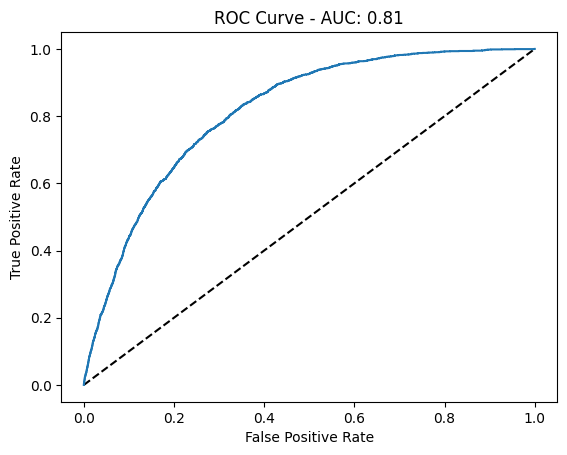

AUC: 0.8144932068966587


Best estimator:XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=480, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


Best parameters:{'n_estimators': 480, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.2}


Best score:0.8315306274814204


Best index:14


Best average score:[0.79910838 0.80065235 0.8

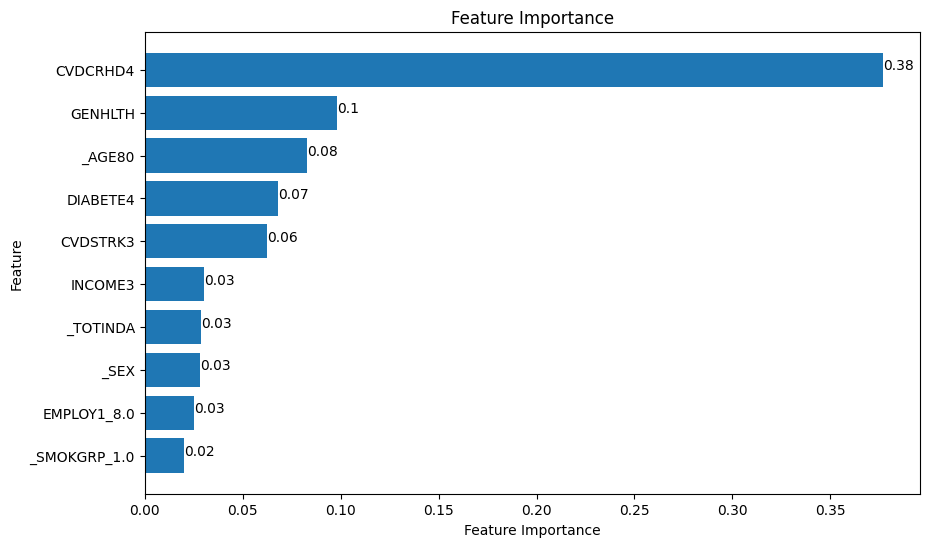

In [ ]:
# Predict the test set using the best model
y_pred = grid_search_xgb.best_estimator_.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = grid_search_xgb.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC: {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

# Print the best model
print(f"\n\nBest estimator:{grid_search_xgb.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{grid_search_xgb.best_params_}")

# Print the best score
print(f"\n\nBest score:{grid_search_xgb.best_score_}")

# Print the best index
print(f"\n\nBest index:{grid_search_xgb.best_index_}")

# Print average score
print(f"\n\nBest average score:{grid_search_xgb.cv_results_['mean_test_score']}")
# Print the results
print(f"\n\nBest results:{grid_search_xgb.cv_results_}")

# Plot Feature Importance
feature_importance = dict(
    zip(X.columns, grid_search_xgb.best_estimator_.feature_importances_)
)

# Plot feature importance with feature importance values as data labels
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features[-10:]],
    [x[1] for x in sorted_features[-10:]],
)
for index, value in enumerate([x[1] for x in sorted_features[-10:]]):
    plt.text(value, index, str(round(value, 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

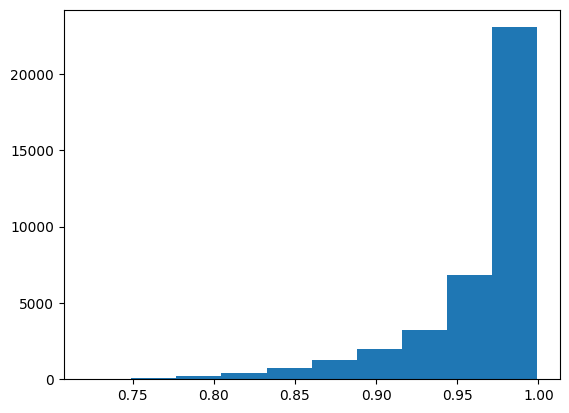

In [ ]:
y_probs = grid_search_xgb.predict_proba(X_test)[:, 1]

# Create a histogram of the probabilities
plt.hist(y_probs, bins=10);

In [ ]:
# Shapley analysis with values and plot
import shap
shap.initjs()
explainer = shap.TreeExplainer(grid_search_xgb.best_estimator_)
shap_values_xgb = explainer.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")

### LGBM

In [ ]:
# Create a LGBM model
clf_lgb = lgb.LGBMClassifier(
    boosting_type="gbdt",
    objective="binary",
    metric="binary_logloss",
    n_estimators=1000,
    reg_alpha=0.002,
    min_child_weight=1,
    max_depth=3,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.8,
)

# Fit the grid search to the data
clf_lgb.fit(X_train, y_train)

# Predict the test set using the LGBM model
y_pred = clf_lgb.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 4076, number of negative: 4106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 8182, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498167 -> initscore=-0.007333
[LightGBM] [Info] Start training from score -0.007333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

,Predicted 0,Predicted 1
Actual 0,26023,9814
Actual 1,331,1613


Accuracy: 0.7314787856329902
Precision: 0.1411569090749978
Recall: 0.8297325102880658


In [ ]:
# Create an LGBMClassifier using the best parameters from the random search
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=20, stop=2000, num=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_child_weight = [1, 2, 4]
# Minimum number of samples required at each leaf node
gamma = [0.1, 0.2, 0.3]
# Learning rate
learning_rate = [0.01, 0.1, 0.2]
# Create the parameter grid
param_grid_lgb = {
    "n_estimators": n_estimators,
    "max_depth": max_depth,
    "min_child_weight": min_child_weight,
    "gamma": gamma,
    "learning_rate": learning_rate,
}

# Create a base model
clf_lgb = lgb.LGBMClassifier(objective="binary", reg_alpha=0.002)

# Create a custom scoring function for precision
precision_scorer = make_scorer(precision_score)

# Instantiate the random search model with precision as the scoring function
grid_search_lgb = RandomizedSearchCV(
    estimator=clf_lgb,
    param_distributions=param_grid_lgb,
    n_iter=20,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring=precision_scorer,
)

# Fit the grid search to the data
grid_search_lgb.fit(X_train, y_train)
print("Best parameters found: ", grid_search_lgb.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 4076, number of negative: 4106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 8182, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498167 -> initscore=-0.007333
[LightGBM] [Info] Start training from score -0.007333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] Unknown parameter: gamma
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86     35837
           1       0.16      0.84      0.27      1944

    accuracy                           0.77     37781
   macro avg       0.57      0.80      0.56     37781
weighted avg       0.95      0.77      0.83     37781

Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,27283,8554
Actual 1,316,1628


Accuracy: 0.7652259072020328
Precision: 0.15989000196425063
Recall: 0.8374485596707819
[LightGBM] [Warning] Unknown parameter: gamma


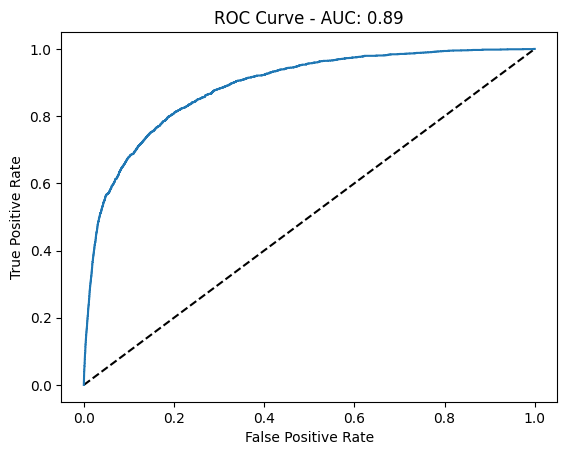

AUC: 0.8873399015386425


Best estimator:LGBMClassifier(gamma=0.2, max_depth=1, min_child_weight=1, n_estimators=480,
               objective='binary', reg_alpha=0.002)


Best parameters:{'n_estimators': 480, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.2}


Best score:0.8149117223893695


Best index:14


Best average score:[0.79445279 0.7814722  0.79411993 0.77956069 0.79045946 0.7809995
 0.79498775 0.79888612 0.80859507 0.78033795 0.7876919  0.78933811
 0.78722948 0.80160946 0.81491172 0.79218359 0.80111387 0.7819623
 0.78834163 0.78843874]


Best results:{'mean_fit_time': array([ 9.29718224, 14.1005818 , 10.57350222, 15.80598823,  0.64024345,
       10.15124035, 13.01466441,  8.42055798,  1.84288669, 10.7242229 ,
       10.58716893,  1.9892091 ,  6.19670415,  7.51280705,  0.50053557,
        3.86577535,  6.1679798 , 10.6164608 ,  4.61139377,  3.4071068 ]), 'std_fit_time': array([1.06528971, 1.03167143, 1.35432951, 0.76124927, 0.0725622 ,
       0.57103058

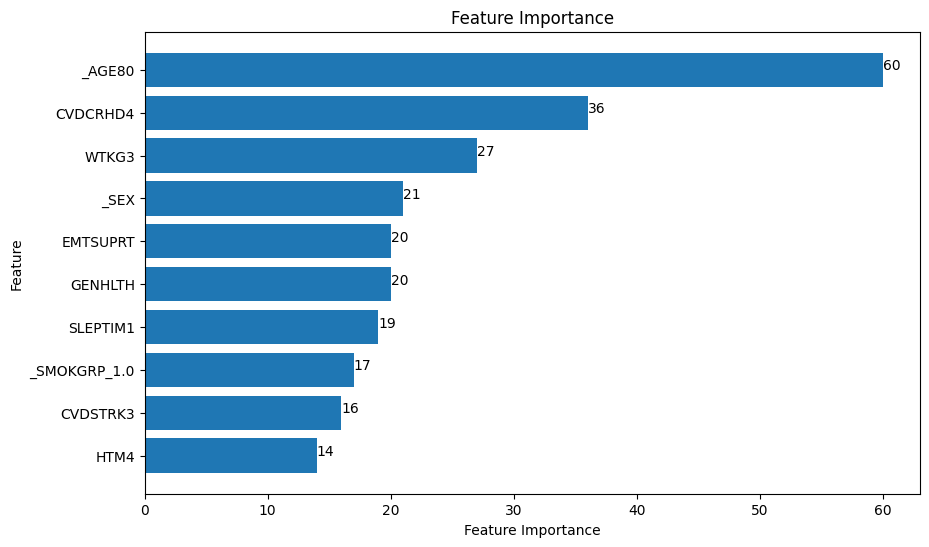

In [ ]:
# Predict the test set using the best model
y_pred = grid_search_lgb.best_estimator_.predict(X_test)

# Evaluate the model
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

# ROC curve
y_pred_prob = grid_search_lgb.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - AUC: {roc_auc_score(y_test, y_pred_prob):0.2f}")
plt.show()

# AUC
print("AUC:", roc_auc_score(y_test, y_pred_prob))

# Print the best model
print(f"\n\nBest estimator:{grid_search_lgb.best_estimator_}")

# Print the best parameters
print(f"\n\nBest parameters:{grid_search_lgb.best_params_}")

# Print the best score
print(f"\n\nBest score:{grid_search_lgb.best_score_}")

# Print the best index
print(f"\n\nBest index:{grid_search_lgb.best_index_}")

# Print average score
print(f"\n\nBest average score:{grid_search_lgb.cv_results_['mean_test_score']}")
# Print the results
print(f"\n\nBest results:{grid_search_lgb.cv_results_}")

# Plot Feature Importance
feature_importance = dict(
    zip(X.columns, grid_search_lgb.best_estimator_.feature_importances_)
)

# Plot feature importance with feature importance values as data labels
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=False)
plt.figure(figsize=(10, 6))
plt.barh(
    [x[0] for x in sorted_features[-10:]],
    [x[1] for x in sorted_features[-10:]],
)
for index, value in enumerate([x[1] for x in sorted_features[-10:]]):
    plt.text(value, index, str(round(value, 2)))
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

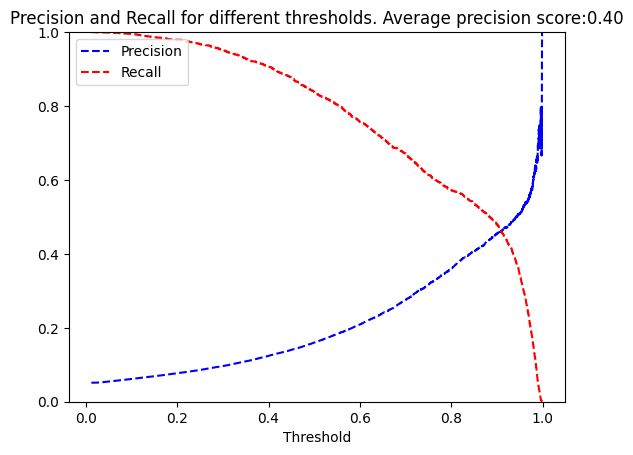

In [ ]:
# Precision and Recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "r--", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")
plt.title(f"Precision and Recall for different thresholds. Average precision score:{average_precision_score(y_test, y_pred_prob):0.2f}")
plt.ylim([0, 1])
plt.show()

## Comparison of results from various models

In [193]:
clf_lr = LogisticRegression(C=0.1, penalty="l2", solver="liblinear")
clf_rf = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features="log2", max_depth=10, bootstrap=True)
clf_xgb = XGBClassifier(reg_alpha=0.002, n_estimators=1000, min_child_weight=1, max_depth=3, learning_rate=0.1, gamma=0.1, colsample_bytree=0.8)
clf_lgb= lgb.LGBMClassifier(boosting_type="gbdt", objective="binary", reg_alpha=0.002, n_estimators=1000, min_child_weight=1, max_depth=3, 
                            learning_rate=0.1, gamma=0.1, colsample_bytree=0.8)

for clf in [clf_lr, clf_rf, clf_xgb, clf_lgb]:
    print (f"\n\nModel: {clf}")
    # Fit the grid search to the data
    clf.fit(X_train, y_train)

    # Predict the test set using the XGB model
    y_pred = clf.predict(X_test)

    # Evaluate the model
    print("Confusion matrix:")
    display(pd.DataFrame(confusion_matrix(y_test, y_pred), index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))



Model: LogisticRegression(C=0.1, solver='liblinear')
Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,20743,15094
Actual 1,124,1820


Accuracy: 0.597204944284164
Precision: 0.10760316897244886
Recall: 0.9362139917695473


Model: RandomForestClassifier(max_depth=10, max_features='log2')
Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,27664,8173
Actual 1,321,1623


Accuracy: 0.77517799952357
Precision: 0.16567986933442222
Recall: 0.8348765432098766


Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Confusion matrix:


,Predicted 0,Predicted 1
Actual 0,19788,16049
Actual 1,143,1801


Accuracy: 0.5714247902384797
Precision: 0.10089635854341737
Recall: 0.926440329218107


Model: LGBMClassifier(colsample_bytree=0.8, gamma=0.1, max_depth=3, min_child_weight=1,
               n_estimators=1000, objective='binary', reg_alpha=0.002)
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 4076, number of negative: 4106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 950
[LightGBM] [Info] Number of data points in the train set: 8182, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498167 -> initscore=-0.007333
[LightGBM] [Info] Start training from score -0.007333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

,Predicted 0,Predicted 1
Actual 0,26335,9502
Actual 1,342,1602


Accuracy: 0.7394457531563484
Precision: 0.14427233429394812
Recall: 0.8240740740740741


## Save Models

In [ ]:
# Save the model
joblib.dump(clf_random.best_estimator_, '../models/rf_model.pkl')

['../models/rf_model.pkl']